<a href="https://colab.research.google.com/github/AKO91/Adult-Income-Analysis/blob/main/Project_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Custom Functions

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Custom Functions

In [50]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")

    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [51]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

## Importing and initial inspection of data

In [52]:
fpath = '/content/drive/MyDrive/CodingDojo/05-IntermediateML/cirrhosis.csv'
df = pd.read_csv(fpath)
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [53]:
df.isna().sum()

,0
ID,0
N_Days,0
Status,0
Drug,106
Age,0
Sex,0
Ascites,106
Hepatomegaly,106
Spiders,106
Edema,0


In [54]:
df.duplicated().sum()

0

In [55]:
df['Stage'].value_counts()

,count
Stage,
3.0,155
4.0,144
2.0,92
1.0,21


In [56]:
df['Stage'].isna().sum()

6

In [57]:
df['Stage'].dropna(inplace=True)

In [58]:
df.dtypes

,0
ID,int64
N_Days,int64
Status,object
Drug,object
Age,int64
Sex,object
Ascites,object
Hepatomegaly,object
Spiders,object
Edema,object


In [59]:
df.set_index('ID', inplace=True)

In [60]:
# Creating a loop to print the details of categorical columns in the dataset
for col in df:
  des_cat = df[col].value_counts()
  if df[col].dtype == object:
    print(f'Details of {col} column:')
    print(des_cat)
    print('\n')

Details of Status column:
Status
C     232
D     161
CL     25
Name: count, dtype: int64


Details of Drug column:
Drug
D-penicillamine    158
Placebo            154
Name: count, dtype: int64


Details of Sex column:
Sex
F    374
M     44
Name: count, dtype: int64


Details of Ascites column:
Ascites
N    288
Y     24
Name: count, dtype: int64


Details of Hepatomegaly column:
Hepatomegaly
Y    160
N    152
Name: count, dtype: int64


Details of Spiders column:
Spiders
N    222
Y     90
Name: count, dtype: int64


Details of Edema column:
Edema
N    354
S     44
Y     20
Name: count, dtype: int64




### Splitting and preprocessing data

In [61]:
X = df.drop(columns='Stage')
y = df['Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [62]:
num_cols = X.select_dtypes('number').columns
cat_cols = X.select_dtypes('object').columns

In [63]:
scaler = StandardScaler()
impute_num = SimpleImputer(strategy='median')
impute_cat = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_pipe = make_pipeline(impute_cat, ohe, scaler)
num_pipe = make_pipeline(impute_num, scaler)
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
num_tuple = ('numeric', num_pipe, num_cols)
preprocesser = ColumnTransformer([ohe_tuple, num_tuple])

In [64]:
X_train_tf = preprocesser.fit_transform(X_train)
X_test_tf = preprocesser.transform(X_test)

## Nueral Network

In [65]:
# Encoding data
encoder = LabelEncoder()

encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)


classes = encoder.classes_

# binarize labels
binarizer = LabelBinarizer()

binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)

In [66]:
input_shape = X_train_tf.shape[1]
input_shape

27

In [67]:
#Output Layer
num_classes = len(classes)
num_classes

5

In [68]:
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(20,
                input_dim =input_shape,
                activation = 'relu'))
    #Output layer
    model.add(Dense(num_classes, activation = 'softmax'))


    # Compile Model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [69]:
multi_model = build_model()
multi_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 20)                  │             560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 665 (2.60 KB)

 Trainable params: 665 (2.60 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
Early = EarlyStopping(monitor = 'val_accuracy', patience=5)

In [71]:
history = multi_model.fit(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=50,
                          verbose=1,
                          callbacks = [Early])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0630 - loss: 2.2608 - precision: 0.0396 - recall: 0.0122 - val_accuracy: 0.0952 - val_loss: 2.2815 - val_precision: 0.0625 - val_recall: 0.0159
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0832 - loss: 2.1317 - precision: 0.0803 - recall: 0.0237 - val_accuracy: 0.0952 - val_loss: 2.1355 - val_precision: 0.0714 - val_recall: 0.0159
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0991 - loss: 1.9650 - precision: 0.0686 - recall: 0.0160 - val_accuracy: 0.0952 - val_loss: 2.0091 - val_precision: 0.0769 - val_recall: 0.0159
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1311 - loss: 1.8595 - precision: 0.0700 - recall: 0.0127 - val_accuracy: 0.1111 - val_loss: 1.8946 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1828 - loss: 1.7697 - precision: 0.1141 - recall: 0.0197 - val_accuracy: 0.1270 - val_loss: 1.7932 - val_

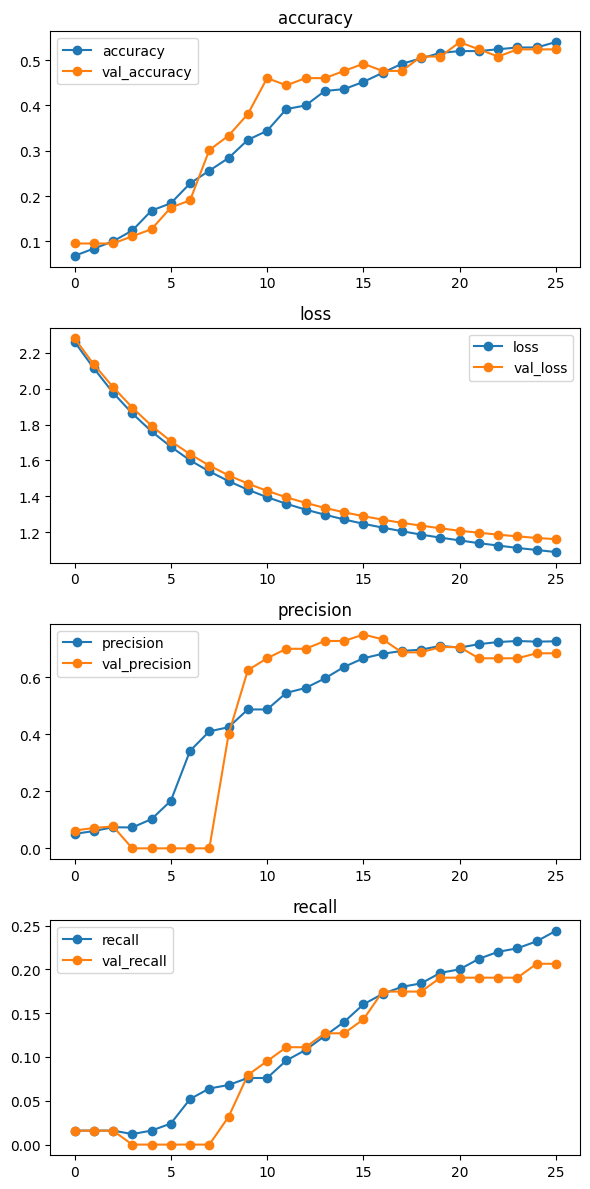

In [72]:
plot_history(history);

*The model performs poorly in all metrics, but there is no overfitting. Increasing the number of epochs can help the model perform better since the loss function is still at about 1.2, which indicates that the model can still learn more.*

In [73]:
raw_pred = multi_model.predict(X_test_tf)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [74]:
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.29      0.19      0.23        21
           2       0.51      0.54      0.52        41
           3       0.48      0.64      0.55        36
           4       0.00      0.00      0.00         3

    accuracy                           0.47       105
   macro avg       0.26      0.27      0.26       105
weighted avg       0.42      0.47      0.44       105



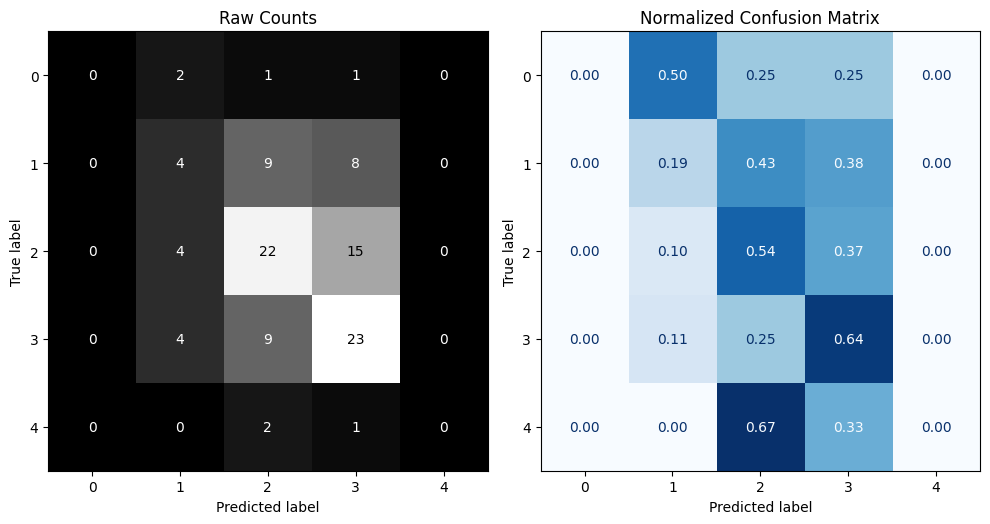

In [75]:
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8))

### Tuning Model

In [76]:
!pip install keras-tuner
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [77]:
def build_model_tuned(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(50,
                input_dim =input_shape,
                activation = 'relu'))
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=5, max_value=50, step=5), activation='relu'))
    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation = 'softmax'))

    # Compile Model
    # Try different optimizers
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [78]:
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [79]:
tuner = kt.Hyperband(build_model_tuned,
                     objective='val_accuracy',
                     max_epochs=50,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Cirrhosis_tuning')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
tuner.search(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=50,
                          verbose=1,
                          callbacks = [Early])

Trial 90 Complete [00h 00m 07s]
val_accuracy: 0.523809552192688

Best val_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 09m 09s


In [81]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 25,
 'dropout_value': 0.4,
 'optimizer': 'rmsprop',
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0049'}

In [82]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,805 (10.96 KB)

 Trainable params: 2,805 (10.96 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history_tuned = best_model.fit(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=50,
                          verbose=1,
                          callbacks = [Early])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.4873 - loss: 1.1137 - precision: 0.6821 - recall: 0.2467 - val_accuracy: 0.6667 - val_loss: 1.0472 - val_precision: 0.8333 - val_recall: 0.3175
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5910 - loss: 0.9912 - precision: 0.7708 - recall: 0.3689 - val_accuracy: 0.6667 - val_loss: 1.0424 - val_precision: 0.8333 - val_recall: 0.3175
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5687 - loss: 1.0096 - precision: 0.7070 - recall: 0.3273 - val_accuracy: 0.6508 - val_loss: 1.0391 - val_precision: 0.8400 - val_recall: 0.3333
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5307 - loss: 1.0620 - precision: 0.7328 - recall: 0.2961 - val_accuracy: 0.6349 - val_loss: 1.0399 - val_precision: 0.8148 - val_recall: 0.3492
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5402 - loss: 0.9964 - precision: 0.7430 - recall: 0.3477 - val_accuracy: 0.6190 - val_loss: 1.0433 - val_pre

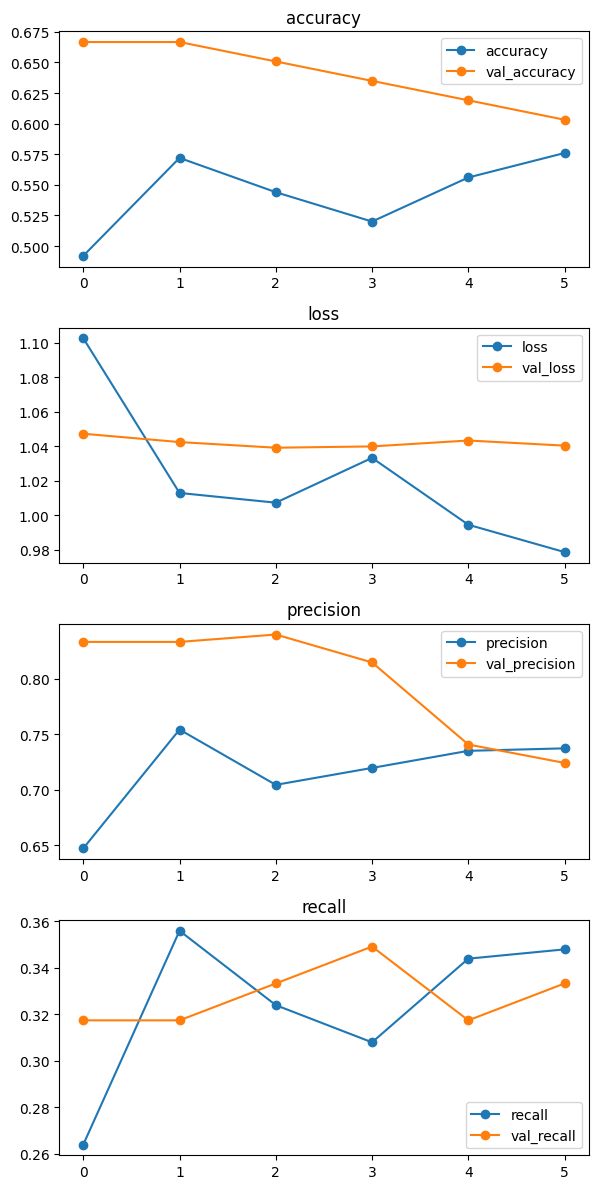

In [84]:
plot_history(history_tuned);

In [85]:
tuner.results_summary(5)


Results summary
Results in KerasTuner/Cirrhosis_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0050 summary
Hyperparameters:
units: 25
dropout_value: 0.4
optimizer: rmsprop
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0049
Score: 0.6666666865348816

Trial 0067 summary
Hyperparameters:
units: 30
dropout_value: 0.1
optimizer: nadam
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0063
Score: 0.6507936716079712

Trial 0069 summary
Hyperparameters:
units: 25
dropout_value: 0.0
optimizer: adam
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0058
Score: 0.6507936716079712

Trial 0072 summary
Hyperparameters:
units: 30
dropout_value: 0.1
optimizer: nadam
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.6507936716079712

Trial 0073 summary
Hyperparameters:
units: 25
dropout_value: 0.

In [86]:
raw_pred_tuned = best_model.predict(X_test_tf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [87]:
y_pred_tuned = np.argmax(raw_pred_tuned, axis=1)
y_true_tuned = np.argmax(y_test_bin, axis=1)

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.30      0.14      0.19        21
           2       0.47      0.56      0.51        41
           3       0.48      0.61      0.54        36
           4       0.00      0.00      0.00         3

    accuracy                           0.46       105
   macro avg       0.25      0.26      0.25       105
weighted avg       0.41      0.46      0.42       105



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


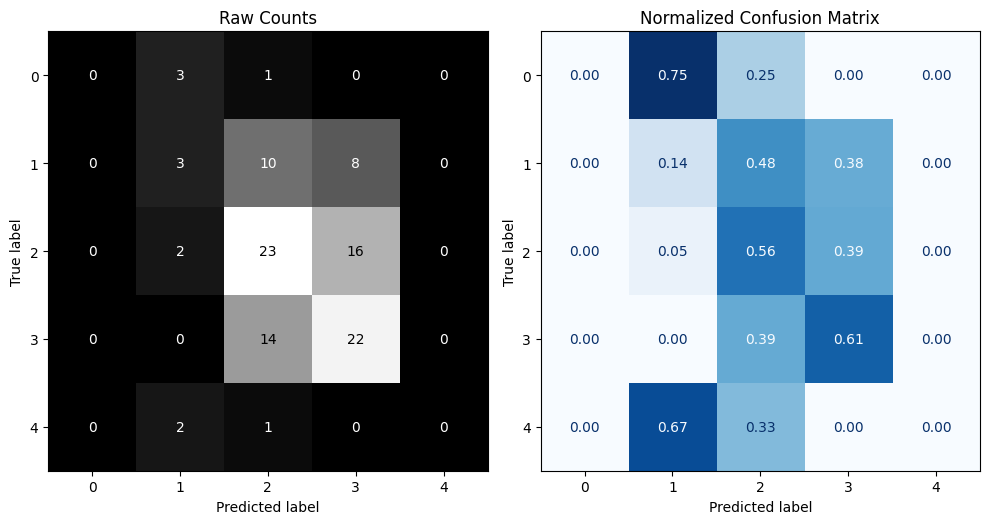

In [88]:
classification_metrics(y_true_tuned, y_pred_tuned, label='Test Data', figsize=(10,8))

*The tuned model performs as poorly as the regular model, and does not fit well on the data.*

* Because the dataset is small, the model could not perform well and learn its intricacies. A more traditional machine learning model could be sufficient for predicting this data, otherwise a significant increase in the size of the data is needed for the model to perform well.